# IAVSAI

#### To start the project:

- First of all, you'll need Onyxia in order to create a new service and launch Vscode-python-gpu.
- Then, please add your Onyxia user's name in the variable below:


In [2]:
user_name = "juliettejin" #username

#### Now
- Run the following commands to install the dependencies
- After that, restart the kernel
- Then you can comment theses commands to not run them again

In [3]:
! pip install nltk
! pip install datasets
! pip install spacy
! pip uninstall -y scipy
! pip install scipy==1.12
! pip install tensorflow

import nltk
nltk.download('punkt')
nltk.download('wordnet')

Found existing installation: scipy 1.12.0
Uninstalling scipy-1.12.0:
  Successfully uninstalled scipy-1.12.0
  Using cached scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.4 MB)


[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/onyxia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
import os
import s3fs
import zipfile

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import word_tokenize          

from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate

#import re

2024-04-24 17:52:10.443589: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 17:52:10.447700: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 17:52:10.503386: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 17:52:11.167966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Export Dataset

In [5]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

# List the challenge's files
fs.ls("civel/diffusion/hackathon-minarm-2024/AIVSAI")
PATH_IN = 'civel/diffusion/hackathon-minarm-2024/AIVSAI/hack_train.csv'
fs.download(PATH_IN, 'data/hack_train.csv')

[None]

In [6]:
def load_csv():
    file_path = "data/hack_train.csv"
    return pd.read_csv(filepath_or_buffer=file_path)
df = load_csv()
df

,text,label,src
0,Little disclaimer: this deals with US laws and...,1,cmv_human
1,"Read: Mentally Retarded Downs. See, we've got ...",1,cmv_human
2,"If any of you frequent rbadhistory, there is a...",1,cmv_human
3,"I believe in a flat tax system, where everyone...",1,cmv_human
4,"Edit: Ok guy's, my views have been changed on ...",1,cmv_human
...,...,...,...
56814,We consider the recovery of a source term f (x...,1,sci_gen_human
56815,"Self-supervised learning (SlfSL), aiming at le...",1,sci_gen_human
56816,Recurrent neural networks (RNNs) have achieved...,1,sci_gen_human
56817,Deep reinforcement learning (DRL) is a booming...,1,sci_gen_human


### Clean Dataframe

In [7]:
def clean_dataframe_new(df):
    df = df.drop_duplicates()
    df = df.dropna()
    
    return df
df = clean_dataframe_new(df)
df

,text,label,src
0,Little disclaimer: this deals with US laws and...,1,cmv_human
1,"Read: Mentally Retarded Downs. See, we've got ...",1,cmv_human
2,"If any of you frequent rbadhistory, there is a...",1,cmv_human
3,"I believe in a flat tax system, where everyone...",1,cmv_human
4,"Edit: Ok guy's, my views have been changed on ...",1,cmv_human
...,...,...,...
56814,We consider the recovery of a source term f (x...,1,sci_gen_human
56815,"Self-supervised learning (SlfSL), aiming at le...",1,sci_gen_human
56816,Recurrent neural networks (RNNs) have achieved...,1,sci_gen_human
56817,Deep reinforcement learning (DRL) is a booming...,1,sci_gen_human


### Save Dataset in Onyxia

- After running the next cell, you will be able to observe the dataset on Onyxia

In [8]:
PATH_OUT = user_name + '/diffusion/projet-mongroupe-hackathon/hack_train.csv'
with fs.open(PATH_OUT, 'w') as file_out:
    df.to_csv(file_out, index=False)

### Clean Dataframe

In [9]:
def clean_dataframe(df):
    df = df.drop_duplicates()
    df = df.dropna()
    return df

### Read From Onyxia

In [10]:
with fs.open(PATH_OUT, mode="r") as file_in:
    df = pd.read_csv(file_in)
    df = clean_dataframe(df)

In [11]:
df.head()

,text,label,src
0,Little disclaimer: this deals with US laws and...,1,cmv_human
1,"Read: Mentally Retarded Downs. See, we've got ...",1,cmv_human
2,"If any of you frequent rbadhistory, there is a...",1,cmv_human
3,"I believe in a flat tax system, where everyone...",1,cmv_human
4,"Edit: Ok guy's, my views have been changed on ...",1,cmv_human


### Statistiques

In [123]:
total_number_of_source = len(df['src'].drop_duplicates())
print("Total number of source:", total_number_of_source)

Total number of source: 322


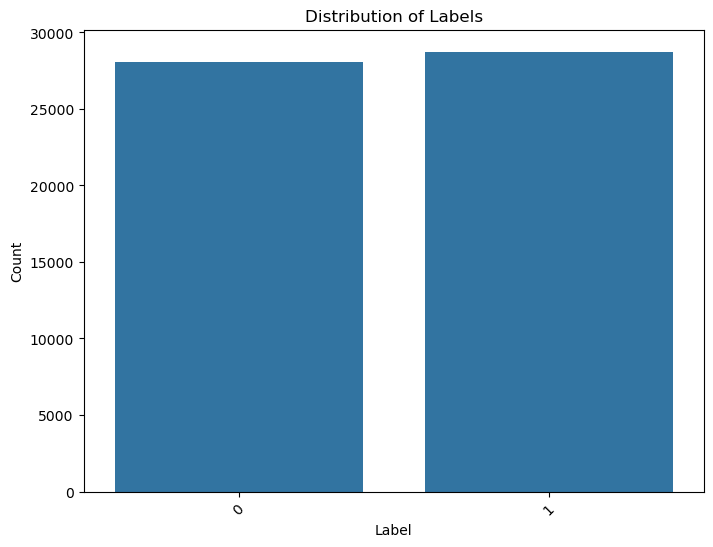

In [124]:
# Distribution of Labels
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

- Equal data distribution for classification is advantageous as it prevents bias, aids generalization, ensures fair evaluation, and enhances learning stability.

### Compare the length of the answers between human and machine

In [128]:
def compareLengthAnswer(data) :

    #Collect the length of the answer
    lengthHumanAnswer = data[data['label'] ==  1]['text'].apply(len)
    lengthChatGPTAnswer = data[data['label'] ==  0]['text'].apply(len)
    
    # Display the graphic
    plt.figure(figsize=(10, 6))
    plt.hist(lengthHumanAnswer, bins=100, alpha=0.5, label='Human Answers')
    plt.hist(lengthChatGPTAnswer, bins=20, alpha=0.5, label='Machine Answers')
    plt.title(' Comparaison: the length of the answers between human and machine')
    plt.xlabel('Number of caracters per response')
    plt.ylabel('Number of response')
    plt.legend()

    plt.yscale('log')
    plt.xlim(left=0)

    plt.grid(True)
    plt.show()

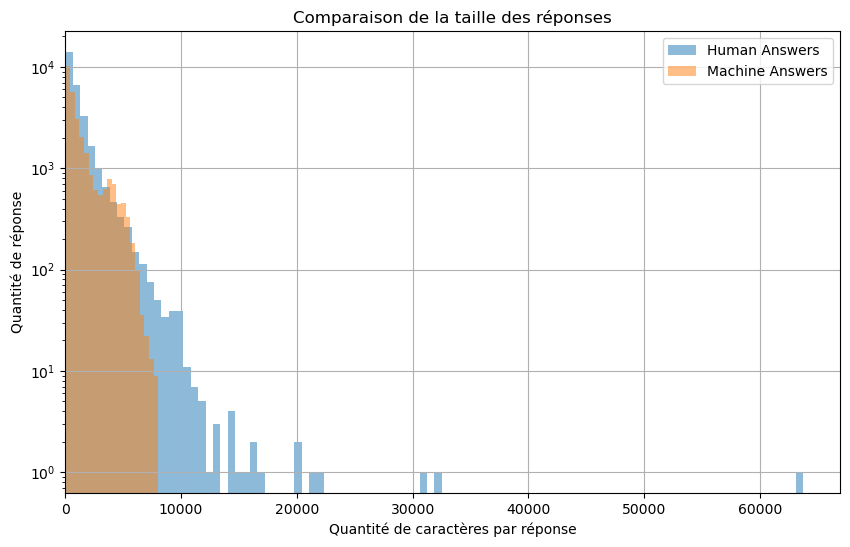

In [126]:
compareLengthAnswer(df)

- We can see that human answers are likely to be longer than machine answers
- Human answers tend to be longer because they include additional context and elaboration, aiming for comprehensive understanding.
- AI-generated responses like mine prioritize brevity while still conveying essential information efficiently.

### Count number of sentences per source

In [131]:
def count_sentences(text):
    # Using regex to detect end of sentense more precisely
    sentences = re.split(r'(?<=[.!?])\s+', text)
    return len([sentence for sentence in sentences if sentence.strip()])

df_final = df.copy()
df_final['human_sentence_count'] = df_final[df_final['label'] ==  1]['text'].apply(count_sentences)
df_final['chatgpt_sentence_count'] = df_final[df_final['label'] ==  0]['text'].apply(count_sentences)

grouped = df_final.groupby('src').agg({
    'human_sentence_count': 'sum',
    'chatgpt_sentence_count': 'sum'
}).reset_index()

grouped

,src,human_sentence_count,chatgpt_sentence_count
0,cmv_human,38731.0,0.0
1,cmv_machine_continuation_13B,0.0,3259.0
2,cmv_machine_continuation_30B,0.0,2743.0
3,cmv_machine_continuation_65B,0.0,3087.0
4,cmv_machine_continuation_7B,0.0,3099.0
...,...,...,...
317,yelp_machine_continuation_opt_iml_max_1.3b,0.0,660.0
318,yelp_machine_continuation_t0_11b,0.0,129.0
319,yelp_machine_continuation_t0_3b,0.0,312.0
320,yelp_machine_continuation_text-davinci-002,0.0,1185.0


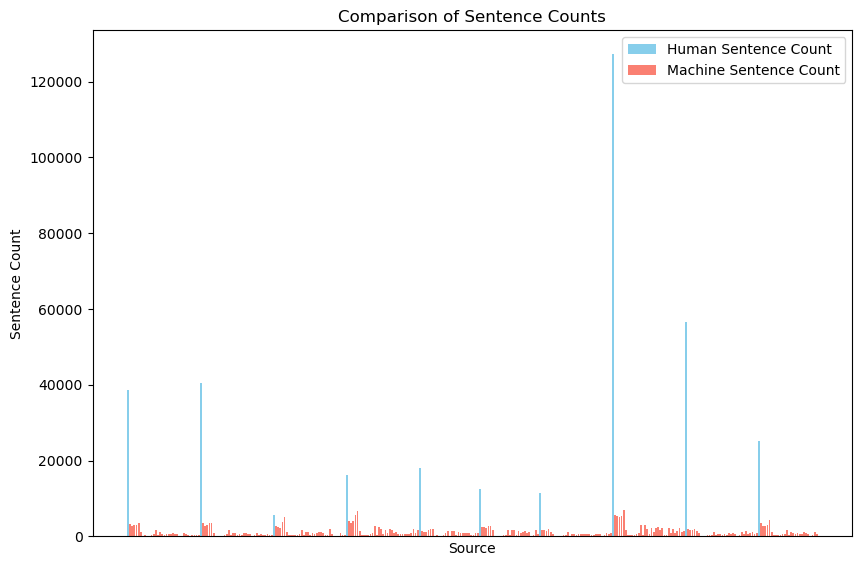

In [145]:
plt.figure(figsize=(10, 6))
plt.bar(grouped['src'], grouped['human_sentence_count'], color='skyblue', label='Human Sentence Count')
plt.bar(grouped['src'], grouped['chatgpt_sentence_count'], color='salmon', label='Machine Sentence Count')
plt.ylabel('Sentence Count')
plt.xlabel('Source')
plt.title('Comparison of Sentence Counts')
plt.legend()
plt.tight_layout()
plt.xticks([])
plt.show()

## Models

## Naive Bayésien (nb)

In [147]:
dataset_nb = df.copy()
dataset_nb

,text,label,src
0,Little disclaimer: this deals with US laws and...,1,cmv_human
1,"Read: Mentally Retarded Downs. See, we've got ...",1,cmv_human
2,"If any of you frequent rbadhistory, there is a...",1,cmv_human
3,"I believe in a flat tax system, where everyone...",1,cmv_human
4,"Edit: Ok guy's, my views have been changed on ...",1,cmv_human
...,...,...,...
56814,We consider the recovery of a source term f (x...,1,sci_gen_human
56815,"Self-supervised learning (SlfSL), aiming at le...",1,sci_gen_human
56816,Recurrent neural networks (RNNs) have achieved...,1,sci_gen_human
56817,Deep reinforcement learning (DRL) is a booming...,1,sci_gen_human


#### Model training

In [148]:
X = dataset_nb['text']
Y = dataset_nb['label']

In [149]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [151]:
# Model construction with a tokenizer and ngram_range
model = make_pipeline(CountVectorizer(tokenizer=word_tokenize, ngram_range = (3,3)), MultinomialNB(alpha=5.0, fit_prior=False))

# Grid search for Naives Bayes

# Define the parameter grid
#param_grid = {
#    'multinomialnb__alpha': [1.0, 2.0, 3.0, 4.0, 5.0],  # Smoothing parameter
#    'multinomialnb__fit_prior': [True, False]       # Whether to learn class prior probabilities
#}
#grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
#grid_search.fit(X_train, Y_train)

# Get the best parameters
#best_params = grid_search.best_params_
#print("Best parameters:", best_params)

In [153]:
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)


Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.99      0.80      5552
           1       0.98      0.54      0.70      5812

    accuracy                           0.76     11364
   macro avg       0.83      0.77      0.75     11364
weighted avg       0.83      0.76      0.75     11364



In [158]:
classification_report_naive_bayes = classification_report(Y_test, y_pred)
print("Classification Report:\n", classification_report_naive_bayes)

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.99      0.80      5552
           1       0.98      0.54      0.70      5812

    accuracy                           0.76     11364
   macro avg       0.83      0.77      0.75     11364
weighted avg       0.83      0.76      0.75     11364



Write the classification report to the file


In [166]:
#file_path = 'classification_report_naive_bayes.txt'
#with open(file_path, 'w') as file:
#    file.write(classification_report_naive_bayes)

In [169]:
file_path = 'classification_report_naive_bayes.txt'
with open(file_path, 'r') as file:
    report_contents = file.read()
print(report_contents)

              precision    recall  f1-score   support

           0       0.67      0.99      0.80      5552
           1       0.98      0.54      0.70      5812

    accuracy                           0.76     11364
   macro avg       0.83      0.77      0.75     11364
weighted avg       0.83      0.76      0.75     11364



#### Confusion matrix

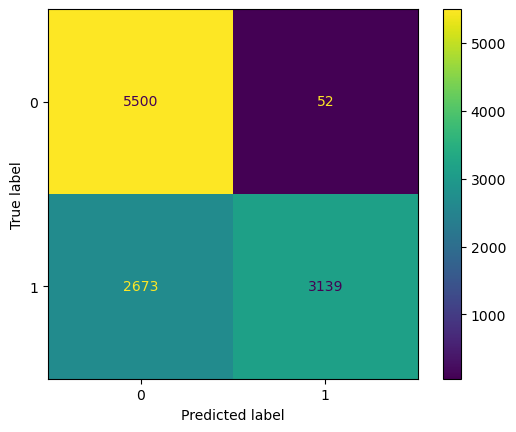

In [154]:
cm = confusion_matrix(Y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

#### Cross Validation

In [155]:
# Perform cross-validation and print the mean accuracy
scoring = 'f1_macro'
scores = cross_val_score(model, X, Y, cv=5, scoring=scoring, n_jobs = -1)
print(f"Mean {scoring}: {scores.mean()}")
print(f"Standard deviation {scoring}: {scores.std()}")

scores_1 = cross_val_score(model, X, Y, cv=10, scoring=scoring, n_jobs = -1)
print(f"Mean {scoring}: {scores_1.mean()}")
print(f"Standard deviation {scoring}: {scores_1.std()}")

/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Mean f1_macro: 0.5604546908799823
Standard deviation f1_macro: 0.0677493721142648


/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extr

KeyboardInterrupt: 

## CNN Model

#### Prepare data and create model

In [ ]:
# Separate text and labels
texts = df['text'].values
labels = df['label'].values

# Tokenization & padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
MAX_LEN = 100

X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_LEN)

# Invert label mapping
label_mapping = {0: 1, 1: 0}

if all(label in [0, 1] for label in labels):
    label_mapping = {0: 1, 1: 0}

labels = np.array([label_mapping[label] for label in labels])

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Model
input_text = Input(shape=(MAX_LEN,), name='input_text')
embed = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128)(input_text)
conv = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(embed)
pool = GlobalMaxPooling1D()(conv)
dense1 = Dense(64, activation='relu')(pool)
output = Dense(1, activation='sigmoid')(dense1)
cnn_model = Model(inputs=input_text, outputs=output)

# Compile
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training
cnn_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))


#### Evaluation and prediction

In [ ]:
# Evaluation
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Prédire les étiquettes sur les données de test
y_pred = (cnn_model.predict(X_test) > 0.5).astype("int32")

# Générer et imprimer le rapport de classification
print("Classification Report for CNN Model:")
print(classification_report(y_test, y_pred))

# Calculer la précision, le rappel et le score F1 pour les deux classes
precision_class_0 = precision_score(y_test, y_pred, pos_label=0)
recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
f1_class_0 = f1_score(y_test, y_pred, pos_label=0)

precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
f1_class_1 = f1_score(y_test, y_pred, pos_label=1)

print("Metrics for class 0:")
print("Precision:", precision_class_0)
print("Recall:", recall_class_0)
print("F1-score:", f1_class_0)

print("\nMetrics for class 1:")
print("Precision:", precision_class_1)
print("Recall:", recall_class_1)
print("F1-score:", f1_class_1)

## Transformer from scratch

#### Prepare data and create model

In [ ]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Dropout, Flatten

# Tokenization & padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
MAX_LEN = 100
X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_LEN)
y = labels

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Reshape input data
X_train = X_train.reshape(X_train.shape[0], MAX_LEN)
X_val = X_val.reshape(X_val.shape[0], MAX_LEN)
X_test = X_test.reshape(X_test.shape[0], MAX_LEN)

# Transformer Model
vocab_size = len(tokenizer.word_index) + 1
max_len = MAX_LEN

input_layer = Input(shape=(max_len,), name='transformer_input')
embed = Embedding(vocab_size, 128, mask_zero=True)(input_layer)
attention = MultiHeadAttention(num_heads=8, key_dim=64)(embed, embed)
attention = LayerNormalization()(attention + embed)
dense = Dense(64, activation='relu')(attention)
dropout = Dropout(0.1)(dense)
output = Dense(64, activation='relu')(dropout)
output = Flatten()(output)
output = Dense(1, activation='sigmoid')(output)

transformer_model = Model(inputs=input_layer, outputs=output)

# Compile Transformer model
transformer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Transformer model
transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

#### Evaluation and prediction

In [170]:
# Evaluate Transformer model
loss, accuracy = transformer_model.evaluate(X_test, y_test)
print(f'Transformer Test Accuracy: {accuracy * 100:.2f}%')

# Prédire les étiquettes sur les données de test
y_pred = (transformer_model.predict(X_test) > 0.5).astype("int32")

# Générer et imprimer le rapport de classification
print("Classification Report for Transformer Model:")
print(classification_report(y_test, y_pred))

# Calculer la précision, le rappel et le score F1 pour les deux classes
precision_class_0 = precision_score(y_test, y_pred, pos_label=0)
recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
f1_class_0 = f1_score(y_test, y_pred, pos_label=0)

precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
f1_class_1 = f1_score(y_test, y_pred, pos_label=1)

print("Metrics for class 0:")
print("Precision:", precision_class_0)
print("Recall:", recall_class_0)
print("F1-score:", f1_class_0)

print("\nMetrics for class 1:")
print("Precision:", precision_class_1)
print("Recall:", recall_class_1)
print("F1-score:", f1_class_1)

NameError: name 'transformer_model' is not defined

## Linear regression (lr)

#### Prepare data

In [16]:
df_lr = df

X_lr = df_lr['text']
y_lr = df_lr['label']

X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_lr, y_lr, test_size=0.2, random_state=42)

text_transformer = CountVectorizer(lowercase=False, tokenizer=word_tokenize, ngram_range = (2,2))

X_lr_train_vectorized = text_transformer.fit_transform(X_lr_train)
X_lr_test_vectorized = text_transformer.transform(X_lr_test)

/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### Model

In [17]:
model_lr = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
model_lr.fit(X_lr_train_vectorized, y_lr_train)


In [34]:
from joblib import dump
from joblib import load

dump(model_lr, 'trained_model_lr.joblib')

['trained_model_lr.joblib']

In [35]:

model_lr = load('trained_model_lr.joblib')

#### Analysis

In [36]:
y_lr_pred = model_lr.predict(X_lr_test_vectorized)
test_accuracy_lr = accuracy_score(y_lr_test, y_lr_pred)
classification_report_lr = classification_report(y_lr_test, y_lr_pred)
print("Classification Report:\n", classification_report_lr)
print("Testing Accuracy:", test_accuracy_lr)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      5552
           1       0.93      0.95      0.94      5812

    accuracy                           0.94     11364
   macro avg       0.94      0.94      0.94     11364
weighted avg       0.94      0.94      0.94     11364

Testing Accuracy: 0.9400739176346357


Write the classification report to the file

In [22]:
#file_path = 'classification_report_logistic_regression.txt'
#with open(file_path, 'w') as file:
#    file.write(classification_report_lr)

In [24]:
file_path = 'classification_report_logisfile_path = 'classification_report_logistic_regression.txt'
with open(file_path, 'r') as file:
    report_contents = file.read()
print(report_contents)tic_regression.txt'
with open(file_path, 'r') as file:
    report_contents = file.read()
print(report_contents)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      5552
           1       0.93      0.95      0.94      5812

    accuracy                           0.94     11364
   macro avg       0.94      0.94      0.94     11364
weighted avg       0.94      0.94      0.94     11364



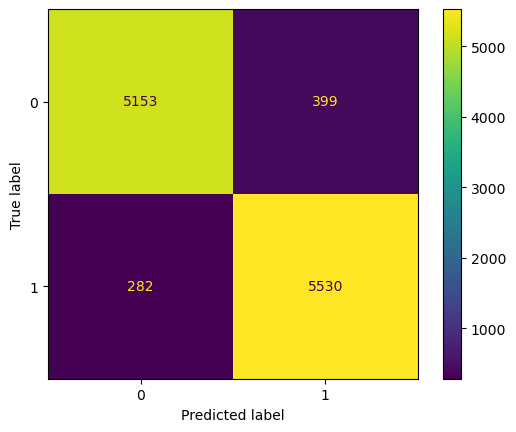

In [25]:
cm = confusion_matrix(y_lr_test, y_lr_pred, labels=model_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lr.classes_)
disp.plot()
plt.show()

In [31]:
model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'))

param_grid = {
    'countvectorizer__lowercase': [False, True],
    'countvectorizer__tokenizer': [word_tokenize],
    'countvectorizer__ngram_range': [(1, 1), (2, 2)],
    'countvectorizer__stop_words': [None, 'english'],
    'logisticregression__C': [0.001, 0.01, 0.1, 1],
    'logisticregression__penalty': ['l1', 'l2'],
}
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_lr_train, y_lr_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extr

Best parameters: {'countvectorizer__lowercase': False, 'countvectorizer__ngram_range': (2, 2), 'countvectorizer__stop_words': 'english', 'countvectorizer__tokenizer': <function word_tokenize at 0x7f5bc536afc0>, 'logisticregression__C': 1, 'logisticregression__penalty': 'l2'}
Best cross-validation score: 0.9308385598688735
Test set score: 0.9391059486096445



In [33]:
# Redirecting output to a file

#gridsearch_lr_file = 'gridsearch_lr.txt'
#with open('gridsearch_lr.txt', 'w') as f:
#    print("Best parameters:", grid_search.best_params_, file=f)
#    print("Best cross-validation score:", grid_search.best_score_, file=f)
#    best_model = grid_search.best_estimator_
#    test_score = best_model.score(X_lr_test, y_lr_test)
#    print("Test set score:", test_score, file=f)

with open(gridsearch_lr_file, 'r') as file:
    gridsearch_contents = file.read()
print(gridsearch_contents)

Best parameters: {'countvectorizer__lowercase': False, 'countvectorizer__ngram_range': (2, 2), 'countvectorizer__stop_words': 'english', 'countvectorizer__tokenizer': <function word_tokenize at 0x7f5bc536afc0>, 'logisticregression__C': 1, 'logisticregression__penalty': 'l2'}
Best cross-validation score: 0.9308385598688735
Test set score: 0.9391059486096445

